5. Building a word2vec model
---------------------------

In [1]:
import collections
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
import time

%matplotlib inline

In [2]:
#Helper Function to handle DL of data from source

url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [3]:
def get_data(f_name):
    with zipfile.ZipFile(f_name) as f:
        nl = f.namelist() #a list of the names of files in the zip directory only one in our cast
        data = f.read(nl[0]).split()
    return data

words = get_data(filename)
print 'Num Words: ', len(words)

Num Words:  17005207


In [4]:
VOCAB_SIZE = 50000

def build_dataset(words, vocab_size = VOCAB_SIZE):
    wd_ctr = collections.Counter(words)
    freq_most_common_wds = wd_ctr.most_common(vocab_size - 1)
    UNK_FREQ = 0
    UNK_IDX = 0

    #build a hash lookup from words to indices. UNK is @ idx 0 and the rest are above that in sequence
    wd_idx = {'UNK': 0}
    for idx, (wd, ct) in enumerate(freq_most_common_wds):
        wd_idx[wd] = (idx + 1)

    #using the above index replace each word with the corresponding ID (0 if it is not in the VOCAB)
    words_to_index = []
    for word in words:
        if word in wd_idx:
            words_to_index.append(wd_idx[word])
        else:
            UNK_FREQ += 1
            words_to_index.append( UNK_IDX )
    rev_wd_idx = dict(zip(wd_idx.values(), wd_idx.keys()))
    freq_most_common_wds.insert(0, ('UNK', UNK_FREQ))
    
    return words_to_index, freq_most_common_wds, wd_idx, rev_wd_idx

data, count, wd_idx, rev_wd_idx = build_dataset(words)

print len(data), data[:10]
print count[:10]
    
    



17005207 [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]
[('UNK', 418391), ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430)]


In [7]:
"""
Not the version from the class notes so replace if it doesnt work
"""
def generate_batch(data, batch_size, window_size):
    batch = []
    labels = []
    for _ in range(batch_size // (2 * window_size)):
        rand_idx = random.randint(window_size, (len(data) - 1) - window_size)
        #print rand_idx
        target = data[rand_idx]
        context_left = data[rand_idx - window_size : rand_idx]
        context_right = data[rand_idx + 1 : (rand_idx + 1) + window_size]
        for context in (context_left + context_right):
            batch.append(target)
            labels.append([context])
    batch = np.array(batch, dtype = np.int32)
    labels = np.array(labels, dtype = np.int32)
    return batch, labels
bs, ws = 20, 1
batch, labels = generate_batch(data, batch_size=bs, window_size = ws)
print '\nwith batch_size = %d and window_size = %d:' % (bs, ws)
print '    batch:', [rev_wd_idx[bi] for bi in batch]
print '    labels:', [rev_wd_idx[li] for li in labels.reshape(s)]

 
with batch_size = 20 and window_size = 1:
    batch: ['force', 'force', 'the', 'the', 'zero', 'zero', 'the', 'the', 'of', 'of', 'made', 'made', 'smaller', 'smaller', 'three', 'three', 'exposed', 'exposed', 'court', 'court']
    labels: ['to', 'her', 'it', 'fastest', 'three', 'th', 'of', 'more', 'inventions', 'the', 'been', 'into', 'the', 'the', 'one', 'one', 'been', 'to', 's', 'of']


In [10]:
#The Model

batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
window_size = 1 # How many words to consider left and right.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 32 # Random set of words to evaluate similarity on.
valid_window = 200 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(1, valid_window), valid_size))
num_neg_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()
with graph.as_default():
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    embeddings = tf.Variable(tf.random_uniform(shape = (VOCAB_SIZE, embedding_size), minval = -1.0, maxval = 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal((VOCAB_SIZE, embedding_size), stddev=1.0 / np.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([VOCAB_SIZE]))
    
    train_embeds = tf.nn.embedding_lookup(embeddings, train_dataset)
    """"
    Compute the softmax loss, using a sample of the negative labels each time.
    used to calculate loss based on a subset of values in the vocabulary (in this case 64)
    the basic workflow: the embedding take a training subset of rows from the vocabulary, which is then used to compute the softmax
    based on the sample calculate the loss for the softmax_weights
    tf.matmul(train_embeds(batch_size, embedding_size), tf.transpose(softmax_weights)(embedding_size, sample_size)) + softmax_bias(, sample_size)
    """
    loss = tf.reduce_mean( 
        tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, train_embeds,
                               train_labels, num_neg_sampled, VOCAB_SIZE))
    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    
    #computes cosine similariyt
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True)) #l2_norm, column vector (VOCAB_SIZE, 1), denominator in cosine sim
    normalized_embeddings = embeddings/norm # 50k x 128 
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset) # 16 x 128
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings)) # 16 x 50000 not immediately obvious, but the mat_mul combined with the 
                                                                                  # normalization when refactored is equivalent to cosine sim, hint factor
                                                                                  # out the A_norm and the B_norm.
    

In [11]:
#Training

NUM_STEPS = 150001
start = time.time()
with tf.Session(graph=graph) as sess:
    sess.run(tf.initialize_all_variables())
    print 'Initialized'
    average_loss = 0.0
    for step in range(NUM_STEPS):
        batch, labels = generate_batch(data, batch_size=batch_size, window_size = window_size)
        feed_dict = {train_dataset: batch,
                     train_labels: labels}
        _, loss_val = sess.run([optimizer, loss], feed_dict = feed_dict)
        average_loss += loss_val
        if step % 2000 == 0:
            print 'Average Loss at step: ', step, ' loss: ', average_loss/2000.0, 'elapsed time:', time.time() - start
            average_loss = 0.0
        if step % 10000 == 0:
            sim = sess.run(similarity)
            for i in range(valid_size):
                valid_word = rev_wd_idx[valid_examples[i]]
                top_k = 8
                nearest = (-sim[i, :]).argsort()[1: top_k + 1]
                top_choices = ', '.join([rev_wd_idx[idx] for idx in nearest])
                print 'Nearest words to:', valid_word, '-', top_choices
    final_embeddings = sess.run(normalized_embeddings)
    print 'total elapsed time: ', time.time() - start, 'Num Iterations: ', NUM_STEPS

Initialized
Average Loss at step:  0  loss:  0.00364464235306 elapsed time: 0.386840820312
Nearest words to: found - endosymbiotic, ahimsa, chipsets, flynn, monitor, contrastive, endosymbiosis, lfar
Nearest words to: during - originator, lemurs, reluctantly, consecutively, mashing, allgemeine, ramgoolam, luce
Nearest words to: high - eastward, seam, treating, deploy, showcased, mppc, meridian, heb
Nearest words to: have - transcriptase, seconds, compensation, microorganism, camp, rajah, usk, haas
Nearest words to: also - philibert, pneumonic, diabetic, studied, caesaris, lineman, bleaching, acuff
Nearest words to: do - garry, farnsworth, bovine, barreled, gonzales, agathocles, quartic, pemberton
Nearest words to: game - stijl, moore, itunes, influx, libertine, solved, chromatin, sparc
Nearest words to: th - historiae, bungee, barra, enamoured, meal, pixels, xcd, grandchildren
Nearest words to: through - aztec, brow, embittered, bigger, justifiable, fayetteville, moravians, shelby
Neare

In [22]:
num_point = 500

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=10000)
embed_2D = tsne.fit_transform(final_embeddings[:num_point, :])

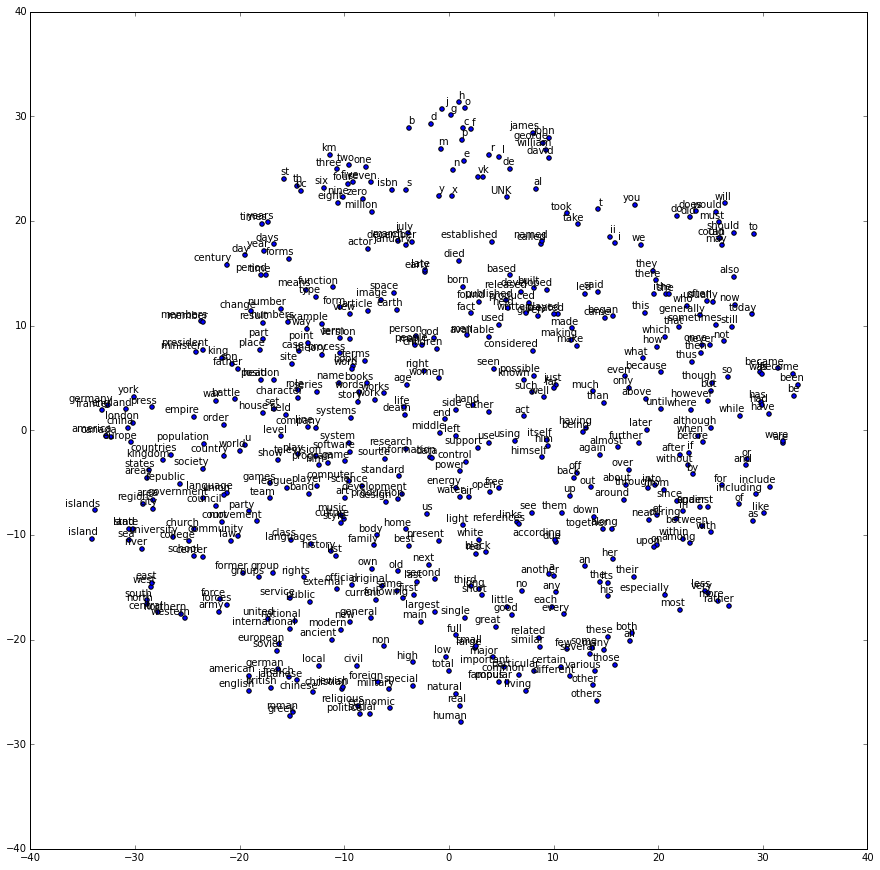

In [23]:
labels = [rev_wd_idx[i] for i in range(num_point)]
pylab.figure(figsize = (15, 15))
for i, label in enumerate(labels):
    x,y = embed_2D[i, :]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2),textcoords='offset points', ha='right', va='bottom')
pylab.show()

In [15]:
embed_2D[0]

array([ 10.85546205,  35.67808601])